<a href="https://colab.research.google.com/github/Rotichkiprono/NeuralNetworks/blob/main/BatchProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETTING UP THE DATA AND SPLITTING HE DATASET**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder #scales them to have 0 mean and unit variance & encodes categical features to numerical
from sklearn.compose import make_column_transformer #combines different preprocessing techniques for different feature types
from sklearn.model_selection import GroupShuffleSplit  #splits data into training and validation sets while preserving groups

from tensorflow import keras #Deep learning library
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('/content/spotify.csv') #loading the data

X = spotify.copy().dropna() #making a copy of the data to avoid altering the original and dropping null values in rows
y = X.pop('track_popularity') # removing the 'track popularity column' since it is the target
artists = X['track_artist'] #stores the artist information

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms'] #Lists numerical features for standardization
features_cat = ['playlist_genre'] #lists categorical features for one hot encoding

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)
#preprocessor that combines standardization and one-hot encoding

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

#splits data into training and validation sets & keeps songs by the same artist togethe

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train) #fits the preprocessor on the training data
X_valid = preprocessor.transform(X_valid) #transforms validation data using preprocessor
y_train = y_train / 100  #Normalizes the target variable (popularity) by dividing by 100
y_valid = y_valid / 100  #Normalizes the validation variable (popularity) by dividing by 100

input_shape = [X_train.shape[1]] #Gets the number of features from the transformed training data
print("Input shape: {}".format(input_shape))

Input shape: [18]


# **DEFINING THE DEEPLEARNING MODEL**

In [ ]:
model = keras.Sequential([ #model stacks layers one after another
    layers.Dense(128, activation='relu', input_shape=input_shape), #dense layer with 128 neurons,activates neurons if their input is positive otherwise it outputs zero
    layers.Dropout(rate=0.3), #randomly drops a certain percentage of neurons during training to prevent overfitting
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1) #single neuron to predict the continuous target variable
])

## **train the model see the effect of adding dropout.**



Minimum Validation Loss: 0.1930


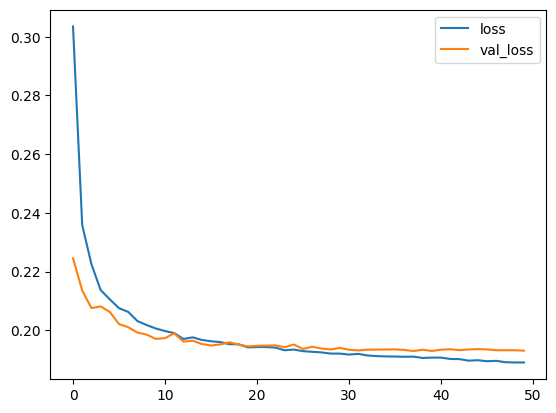

In [ ]:
model.compile(
    optimizer='adam', #adaptive learning rate optimizer that adjusts the learning rate for each parameter
    loss='mae', #measures how well the model's predictions match the actual target values
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid), #validation data for monitoring the model's performance during training
    batch_size=512, #number of samples processed before updating the model's weights.
    epochs=50, #epoch is one complete pass through the entire training dataset
    verbose=0, #no training logs will be printed during training
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

## **ANOTHER DATASET: FOR COMPARISON**

In [ ]:
import pandas as pd

concrete = pd.read_csv('/content/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

Minimum Validation Loss: 3.9995


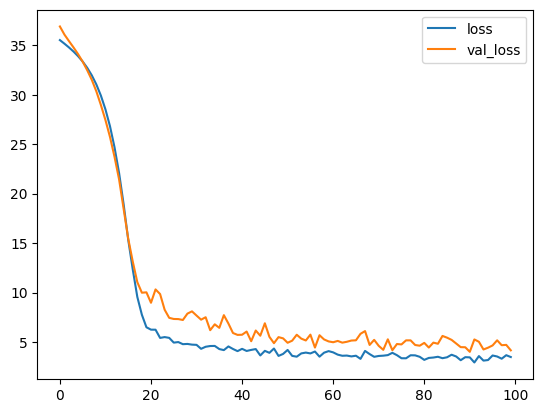

In [ ]:
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

#Trying to train this network on this dataset will usually fail.